In [1]:
import ipywidgets as widgets
import pandas as pd
import qgrid
import matplotlib.pyplot as plt
import matplotlib.ticker as mt
from datetime import datetime
import numpy as np

## Setting float format options

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

# Data import

## Importing SKU Master

By using an appropriate extension cells can be dited inplace like in excel. I would still prefer data cleaning in excel, depending on the case.

In [3]:
sku_master = pd.read_excel(io = 'sample_data.xlsx', sheet_name = 'SKU Master')
qgrid.show_grid(sku_master)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Importing the sales data for one of the stores

In [4]:
sales_data = pd.read_excel(io = 'sample_data.xlsx', sheet_name = 'Store 312')
qgrid.show_grid(sales_data)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [5]:
merged_dataset = pd.merge(left = sales_data, right = sku_master, on = 'SKU')
qgrid.show_grid(merged_dataset)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [6]:
#checking datatypes
merged_dataset.dtypes

DB_ID                  float64
SKU                     object
Store                  float64
Date            datetime64[ns]
Unit Sales              object
Dollar Sales           float64
Department               int64
Class                    int64
Style                    int64
Color                    int64
Cost                   float64
Price                  float64
Vendor                  object
dtype: object

In [7]:
#assign datatype 
merged_dataset["Department"] = merged_dataset['Department'].astype('str')
merged_dataset["SKU"] = merged_dataset['SKU'].astype('str')
merged_dataset["Color"] = merged_dataset['Color'].astype('str')
merged_dataset.dtypes

DB_ID                  float64
SKU                     object
Store                  float64
Date            datetime64[ns]
Unit Sales              object
Dollar Sales           float64
Department              object
Class                    int64
Style                    int64
Color                   object
Cost                   float64
Price                  float64
Vendor                  object
dtype: object

I will take inner quartiles of dollar sales to remove outliers from plots.

In [8]:
sales_25pc = merged_dataset['Dollar Sales'].describe()['25%']
sales_75pc = merged_dataset['Dollar Sales'].describe()['75%']

inner_quartiles = (merged_dataset['Dollar Sales'] > sales_25pc) & (merged_dataset['Dollar Sales'] <= sales_75pc)
filtered_df=(merged_dataset.loc[inner_quartiles])
qgrid.show_grid(filtered_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Interactive elements can be used for easy use. It it possible to relatively easily create full dashboards, like here: [click](https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916)

In [9]:
dates = filtered_df['Date'].sort_values()
date_range = (min(dates),max(dates))
options = [(date.strftime(' %d/%m/%Y ')) for date in dates]


selection_range_slider = widgets.SelectionRangeSlider(
    options= options,
    index=(0, len(options)-1),
    description='Dates',
    layout={'width': '600px'},
    )


def updater(dates):
    df = filtered_df
    mask = (df['Date'] > dates[0]) & (df['Date'] <= dates[1])
    df = df.loc[mask]
    
    fig, ax = plt.subplots()
    ax.bar(df['Date'], df['Dollar Sales'])
    plt.setp(ax.get_xticklabels(), rotation=45)
    plt.show()

interactive_plot = widgets.interact(updater, dates = selection_range_slider)



interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 1608), layout=Layout(width='600px'),…

In [10]:
merged_dataset.describe()

,DB_ID,Store,Dollar Sales,Class,Style,Cost,Price
count,"3,341.00","3,341.00","3,281.00","3,341.00","3,341.00","3,341.00","3,341.00"
mean,"554,911.04",312.00,"1,208.85",88.10,31.25,10.23,14.71
std,"719,873.46",0.00,"21,401.07",93.67,19.63,6.72,8.24
min,"79,444.00",312.00,-59.94,4.00,1.00,2.50,6.99
25%,"89,642.00",312.00,19.98,5.00,12.00,7.50,9.99
50%,"93,986.00",312.00,39.96,24.00,20.00,7.50,9.99
75%,"1,000,742.00",312.00,68.97,201.00,55.00,14.50,22.99
max,"2,001,795.00",312.00,"599,400.00",300.00,55.00,25.00,31.99


In [11]:
#summarising by SKU

df = merged_dataset.groupby(by ='SKU', as_index = False).sum()
df.sort_values(by='Dollar Sales', inplace = True, ascending = False, )
df.reset_index(inplace = True)
df["% of Sales"] = df["Dollar Sales"].cumsum()/df["Dollar Sales"].sum() * 100
df[['SKU', 'Dollar Sales', '% of Sales']]

,SKU,Dollar Sales,% of Sales
0,50012011250,"3,717,570.51",93.73
1,8000451112,"152,318.02",97.57
2,8000520021,"27,392.58",98.26
3,7312455530,"26,231.59",98.92
4,7312455520,"20,773.73",99.45
5,50013000110,"10,404.99",99.71
6,50012011240,"10,077.57",99.96
7,50012011341,"1,457.16",100.00


# Creating a pareto plot

please note that graphics is the most time-consuming thing to create due to multiple possible parameters, although very flexible.

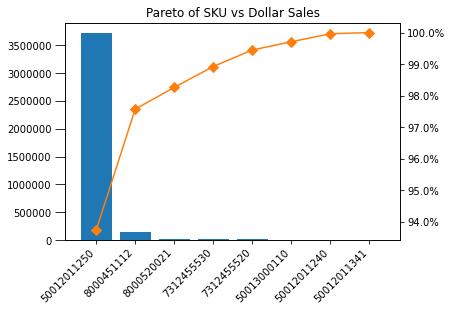

In [12]:
fig, ax = plt.subplots()
plt.title('Pareto of SKU vs Dollar Sales')


ax.bar(df['SKU'],df["Dollar Sales"])
ax2 = ax.twinx()
ax2.plot(df['SKU'], df["% of Sales"], color="C1", marker="D", ms=7)

# ax.yaxis.get_major_formatter().set_useOffset(False)
ax.yaxis.get_major_formatter().set_scientific(False)
ax2.yaxis.set_major_formatter(mt.PercentFormatter())

ax.tick_params(axis = 'y', length = 10)

labels = ax.get_xticklabels()
plt.setp(labels, rotation = 45, horizontalalignment = 'right')

plt.show()

Code can also be hidden like this for reporting purposes

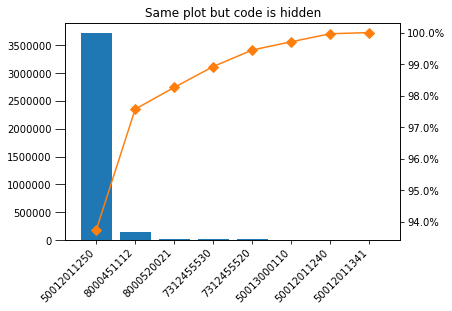

In [13]:
fig, ax = plt.subplots()
plt.title('Same plot but code is hidden')


ax.bar(df['SKU'],df["Dollar Sales"])
ax2 = ax.twinx()
ax2.plot(df['SKU'], df["% of Sales"], color="C1", marker="D", ms=7)

# ax.yaxis.get_major_formatter().set_useOffset(False)
ax.yaxis.get_major_formatter().set_scientific(False)
ax2.yaxis.set_major_formatter(mt.PercentFormatter())

ax.tick_params(axis = 'y', length = 10)

labels = ax.get_xticklabels()
plt.setp(labels, rotation = 45, horizontalalignment = 'right')

plt.show()